In [15]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt

sns.set(style='white', palette='deep', color_codes=True)

%matplotlib inline



In [16]:
np.random.seed(1)

# Number of training points
n = 30
X0 = np.sort(3 * np.random.rand(n))[:, None]

# Number of points at which to interpolate
m = 100
X = np.linspace(0, 3, m)[:, None]

# Covariance kernel parameters
noise = 0.1
lengthscale = 0.3
f_scale = 1

cov = f_scale * pm.gp.cov.ExpQuad(1, lengthscale)
K = cov(X0)
K_s = cov(X0, X)
K_noise = K + noise * tt.eye(n)

# Add very slight perturbation to the covariance matrix diagonal to improve numerical stability
K_stable = K + 1e-12 * tt.eye(n)

# Observed data
f = np.random.multivariate_normal(mean=np.zeros(n), cov=K_noise.eval())

INFO (theano.gof.compilelock): Refreshing lock /local00/home/D58174/.theano/compiledir_Linux-3.2-bpo.4-amd64-x86_64-with-debian-6.0.10--2.7.13-64/lock_dir/lock


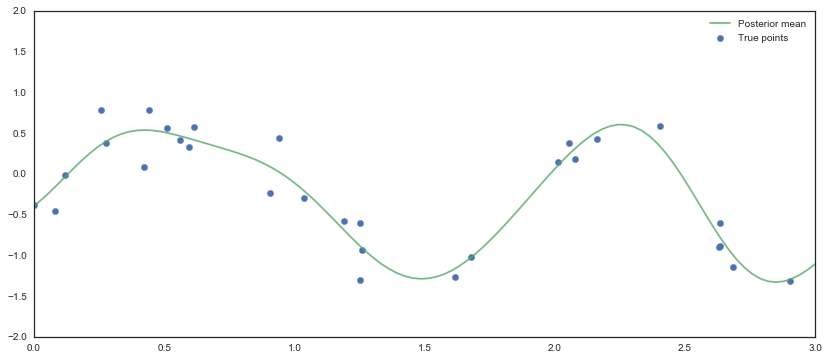

In [24]:
fig, ax = plt.subplots(figsize=(14, 6));
ax.scatter(X0, f, s=40, color='b', label='True points');

# Analytically compute posterior mean
L = np.linalg.cholesky(K_noise.eval())
alpha = np.linalg.solve(L.T, np.linalg.solve(L, f))
post_mean = np.dot(K_s.T.eval(), alpha)

ax.plot(X, post_mean, color='g', alpha=0.8, label='Posterior mean');

ax.set_xlim(0, 3);
ax.set_ylim(-2, 2);
ax.legend();

In [25]:
%%time
with pm.Model() as model:
    # The actual distribution of f_sample doesn't matter as long as the shape is right since it's only used
    # as a dummy variable for slice sampling with the given prior
    f_sample = pm.Flat('f_sample', shape=(n, ))

    # Likelihood
    y = pm.MvNormal('y', observed=f, mu=f_sample, cov=noise * tt.eye(n), shape=n)

    # Interpolate function values using noisy covariance matrix
    L = tt.slinalg.cholesky(K_noise) 
    f_pred = pm.Deterministic('f_pred', tt.dot(K_s.T, tt.slinalg.solve(L.T, tt.slinalg.solve(L, f_sample))))

    # Use elliptical slice sampling
    ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K_stable)
    trace = pm.sample(10000, start=model.test_point, step=[ess_step], progressbar=False, random_seed=1)

CPU times: user 54min 11s, sys: 1min 22s, total: 55min 34s
Wall time: 7min 10s


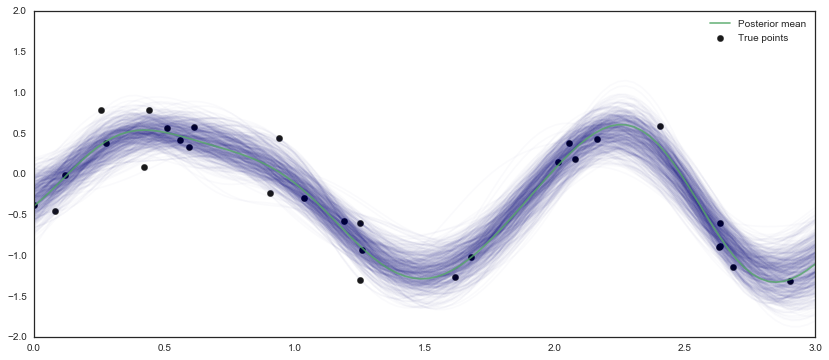

In [23]:
fig, ax = plt.subplots(figsize=(14, 6));
for idx in np.random.randint(0, 5000, 500):
    ax.plot(X, trace['f_pred'][idx],  alpha=0.02, color='navy')
ax.scatter(X0, f, s=40, color='k', label='True points');
ax.plot(X, post_mean, color='g', alpha=0.8, label='Posterior mean');
ax.legend();
ax.set_xlim(0, 3);
ax.set_ylim(-2, 2);